In [254]:
import multiprocessing as mp

import string
import pickle
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

In [255]:
language = 'en'
assert(language in ['en', 'fr', 'es'])

In [256]:
numberbatch = pickle.load(open(f"/data/zeste_cache/numberbatch-{language}-19.08.pickle", 'rb'))

In [257]:
len(numberbatch.vocab)

516782

In [258]:
! ls datasets/silknow

en_material_post2.csv	  zeste_material_en_post.csv
en_technique_post2.csv	  zeste_material_es_post.csv
es_material_post2.csv	  zeste_technique_en_post.csv
es_technique_post2.csv	  zeste_technique_es_post.csv
es_visual_item_post2.csv  zeste_visual_item_es_post.csv


In [259]:
ds_techniques = pd.read_csv('datasets/silknow/en_technique_post2.csv').rename(columns={'technique':'label'})
ds_techniques.label = ds_techniques.label.str.lower()
ds_techniques.head()

,text,label
0,This Dutch sampler is an of example a practica...,embroidery
1,"British wool embroidery, known as crewel embro...",embroidery
2,We may never know what inspired nine-year-old ...,embroidery
3,Band samplers are composed of horizontal rows ...,embroidery
4,Whitework samplers typically consist of a vari...,embroidery


In [260]:
ds_techniques.label.value_counts()

embroidery            343
velvet                236
brocaded              190
satin (fabric)         93
tabby (silk weave)     37
muslin                 30
damask                 25
voided velvet           1
Name: label, dtype: int64

In [261]:
len(ds_techniques)

955

In [262]:
def get_word_neighborhood(word, depth=2, allowed_rels='all', keep='top20000', language=language):
    neighborhood = pickle.load(open('/data/zeste_cache/neighborhoods_'+language+'/'+word+'.pickle', 'rb'))
    neighborhood_words = list(neighborhood.keys())
    
    if allowed_rels != 'all':
        for n in neighborhood_words:
            if all(rel not in neighborhood[n]['rels'] for rel in allowed_rels):
                del neighborhood[n]
                continue

    to_visit_next = list(neighborhood.keys())
    
    while depth > 1:
        additions = []
        while len(to_visit_next) > 0:
            w = to_visit_next.pop()
            nn = get_word_neighborhood(w, depth=1, allowed_rels=allowed_rels)
            for ww in nn:
                if ww in neighborhood:
                    neighborhood[ww]['from'].append(w)
                    neighborhood[ww]['rels'].extend(['<>'] + nn[ww]['rels'])
                else:
                    neighborhood[ww] = {}
                    neighborhood[ww]['from'] = [w]
                    neighborhood[ww]['rels'] = nn[ww]['rels']
                    if '/c/'+language+'/'+word in numberbatch and '/c/'+language+'/'+ww in numberbatch:
                        neighborhood[ww]['sim'] = numberbatch.similarity('/c/'+language+'/'+word, '/c/'+language+'/'+ww)
                    else:
                        neighborhood[ww]['sim'] = 0.0
                    additions.append(ww)
        to_visit_next = additions
        depth -= 1
    
    if keep.startswith('top'):
        k = int(keep.split('top')[1])
        all_scores = [neighborhood[kw]['sim'] for kw in neighborhood]
        all_words = list(neighborhood.keys())
        if k < len(all_scores):
            lowest_top = sorted(all_scores, reverse=True)[k]
            for kw in all_words:
                if neighborhood[kw]['sim'] <= lowest_top:
                    del neighborhood[kw]
    
    return neighborhood

In [263]:
def preprocess(doc):
    doc = ''.join(c for c in doc if c not in string.punctuation or c == ' ').lower()
    doc_tokens = doc.split(' ')
    doc_tokens = [w.lower() for w in doc_tokens]
    doc_tokens = [w for w in doc_tokens if w not in stopwords.words('english')]
    doc_tokens = [w.replace('"', '').replace('?', '') for w in doc_tokens]
    doc_tokens = [w.replace('-', '_') for w in doc_tokens if w != '']

    return doc_tokens

In [264]:
def get_words_neighborhood(words, depth=2, allowed_rels='all', keep='top20000', language=language):
    words = words.split(';')
    ns = []
    
    for word in words:
        ns.append(get_word_neighborhood(word, depth=depth, allowed_rels=allowed_rels, keep=keep, language=language))
    neighborhood = ns[0].copy()
    
    for w, nn in zip(words[1:], ns[1:]):
        for ww in nn:
            if ww in neighborhood:
                neighborhood[ww]['from'].append(w)
                neighborhood[ww]['rels'].extend(['<>'] + nn[ww]['rels'])
                neighborhood[ww]['sim'] = max(neighborhood[ww]['sim'], nn[ww]['sim'])
            else:
                neighborhood[ww] = {}
                neighborhood[ww]['from'] = [w]
                neighborhood[ww]['rels'] = nn[ww]['rels']
                neighborhood[ww]['sim']  = nn[ww]['sim']

    return neighborhood

In [265]:
sorted(ds_techniques.label.unique())

['brocaded',
 'damask',
 'embroidery',
 'muslin',
 'satin (fabric)',
 'tabby (silk weave)',
 'velvet',
 'voided velvet']

In [266]:
get_word_neighborhood('rose', 1, 'all').keys()

dict_keys(['rose', 'musical_artist', 'tea_rose', 'rosa_laevigata', 'rosebud', 'rose_colored', 'rosemaling', 'roseless', 'rosa_rubiginosa', 'rosaceae', 'rose_bowl', 'old_rose', 'rosé', 'шипшина', 'rosewater', 'roselike', 'roze', 'ruusa', 'roser', 'roseling', 'serviceberry', 'rosaniline', 'musk_rose', 'վարդենի', 'itburnu', 'rose_cold', 'compass_rose', 'rosa_pimpinellifolia', 'rising', 'quincite', 'roseness', 'rosewood', 'purple', 'rose_water', 'mahaleb', 'arctic_raspberry', 'rise', 'black_spot', 'jetbead', 'rous', 'rosehip', 'rosa_omeiensis', 'rose_topaz', 'roziero', 'redden', 'rosa_canina', 'amelanchier', 'rosaceous', 'rosa_foetida', 'lolajöb', 'thorn', 'rosed', 'rosarian', 'rosula', 'noisette', 'jack', 'ורדא', 'rosa_rugosa', 'rock_rose', 'rosa_damascena', 'rosen', 'english_rose', 'pop_music', 'pink', 'roseleaf', 'rose_cut', 'china_rose', 'hawthorn', 'mawar', 'rooj', 'garden', 'rose_window', 'rose_syrup', 'red', 'hybrid_tea', 'rosulate', 'rosebush', 'rose_slug', 'compass_card', 'rose_ch

In [267]:
"""mapping = {  'brocade': 'brocade',
             'brocatelle': 'brocatelle',
             'chiné': 'chiné',
             'damask': 'damask',
             'embroidery': "embroidery",
             'florentine': "florentine",
             'gros': "gros",
             'jacquard weave': "jacquard_loom",
             'lampas': "lampas",
             'moiré' : 'moiré',
             'pattern weft': "weft",
             'plain': "plain",
             'velvet': "velvet"}"""


mapping = { 'brocaded':'brocade',
            'damask':'damask',
            'embroidery':'embroidery',
            'tabby (silk weave)':'tabby',
            'velvet':'velvet',
            'satin (fabric)':'satin',
            'muslin':'tabby',
             'voided velvet':'velvet'}

labels = sorted(set(mapping.values()))
print(len(labels))
print(labels)

6
['brocade', 'damask', 'embroidery', 'satin', 'tabby', 'velvet']


In [268]:
%%time
pbar = tqdm(labels)

labels_cgr = {}
for label in pbar:
    pbar.set_description(label)
    labels_cgr[label] = get_words_neighborhood(label, 2, 'all', keep='top20000')


CPU times: user 303 ms, sys: 30.7 ms, total: 334 ms
Wall time: 327 ms


In [269]:
{l:len(labels_cgr[l]) for l in labels_cgr}

{'brocade': 2733,
 'damask': 2694,
 'embroidery': 4351,
 'satin': 5403,
 'tabby': 2177,
 'velvet': 84}

In [270]:
labels_cgr.keys()

dict_keys(['brocade', 'damask', 'embroidery', 'satin', 'tabby', 'velvet'])

In [271]:
def get_document_score(doc, label_neighborhood):
    # tokens = preprocess(doc)
    if type(doc) == str:
        doc = doc.split(' ')
    tokens = doc
    related_words = []
    score = 0
    for token in tokens: 
        if token in label_neighborhood:
            similarity = label_neighborhood[token]['sim']
            if similarity > 0:
                related_words.append((token, label_neighborhood[token]['rels'][0], similarity))
                score += similarity
        
    return score# , sorted(related_words, key=lambda t: -t[-1])

In [272]:
ds_techniques.text[0]

'This Dutch sampler is an of example a practical working document, with various small patterns and motifs scattered across the surface of the cloth in different orientations making the best use of the available space on the foundation fabric. Apparently the women of Marken Island kept their samplers in or near their kitchens for handy reference. This practice has caused the samplers from this area to be discolored from exposure to the fumes and residue from cooking fires.'

In [273]:
data_silknow = ds_techniques.text.tolist()

In [274]:
print("Number of processors: ", mp.cpu_count())

Number of processors:  32


In [275]:
%%time
with mp.Pool(mp.cpu_count()) as pool:
    data_preprocessed = pool.map(preprocess, ds_techniques.text)

CPU times: user 180 ms, sys: 1.45 s, total: 1.63 s
Wall time: 2.21 s


In [276]:
def scoring_silknow(doc, labels_ns=labels_cgr):
    return np.argmax([get_document_score(doc, labels_ns[l]) for l in sorted(labels_ns.keys())])

In [277]:
def generate_predictions(corpus_preprocessed, labels_cgr):
    with mp.Pool(processes=mp.cpu_count()) as pool:
        predictions = pool.map(scoring_silknow, corpus_preprocessed)
    return predictions

In [278]:
%%time
predictions = generate_predictions(data_preprocessed, labels_cgr)

CPU times: user 45.7 ms, sys: 1.33 s, total: 1.37 s
Wall time: 1.26 s


In [279]:


predictions[:10]

[5, 2, 0, 2, 2, 5, 5, 0, 0, 5]

In [280]:

prediction_labels = [labels[p] for p in predictions]

In [281]:
set(prediction_labels)

{'brocade', 'damask', 'embroidery', 'satin', 'tabby', 'velvet'}

In [282]:
true_labels = [mapping[l] for l in ds_techniques.label.tolist()]

# Techniques

In [283]:
print(classification_report(prediction_labels, true_labels, digits=3))
m = np.asarray(prediction_labels)
ds_techniques["predictions"] = m 
ds_techniques.to_csv('techniques-es-predictions.csv')

              precision    recall  f1-score   support

     brocade      0.274     0.239     0.255       218
      damask      0.520     0.342     0.413        38
  embroidery      0.324     0.874     0.472       127
       satin      0.763     0.257     0.385       276
       tabby      0.015     0.500     0.029         2
      velvet      0.620     0.500     0.554       294

    accuracy                          0.414       955
   macro avg      0.419     0.452     0.351       955
weighted avg      0.538     0.414     0.419       955



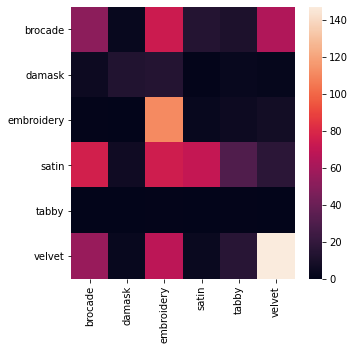

In [284]:
cm = confusion_matrix(prediction_labels, true_labels)
cm_df = pd.DataFrame(cm, columns=labels, index=labels)
plt.figure(figsize = (5,5))
sns.heatmap(cm_df)

# "Top-k" evaluation

In [285]:
k = 2
def scoring_silknow_top_n(doc, labels_ns=labels_cgr, n=k):
    return np.argsort([get_document_score(doc, labels_ns[l]) for l in sorted(labels_ns.keys())])[:-(n+1):-1]
def generate_top_predictions(corpus_preprocessed, labels_cgr):
    with mp.Pool(processes=mp.cpu_count()) as pool:
        predictions = pool.map(scoring_silknow_top_n, corpus_preprocessed)
    return predictions
true_labels = [mapping[l] for l in ds_techniques.label.tolist()]
topk_predictions_lists = generate_top_predictions(data_preprocessed, labels_cgr)
prediction_labels_lists = [[labels[l] for l in p] for p in topk_predictions_lists]
topk_predictions = []

for i, gt_label in enumerate(true_labels):
    topk_predictions.append(gt_label if gt_label in prediction_labels_lists[i] else prediction_labels_lists[i][0])
print(classification_report(topk_predictions, true_labels, digits=3))

              precision    recall  f1-score   support

     brocade      0.516     0.933     0.664       105
      damask      0.600     0.441     0.508        34
  embroidery      0.402     0.926     0.561       149
       satin      0.785     0.369     0.502       198
       tabby      0.313     1.000     0.477        21
      velvet      0.983     0.520     0.680       448

    accuracy                          0.605       955
   macro avg      0.600     0.698     0.566       955
weighted avg      0.772     0.605     0.612       955



In [286]:
k = 3
def scoring_silknow_top_n(doc, labels_ns=labels_cgr, n=k):
    return np.argsort([get_document_score(doc, labels_ns[l]) for l in sorted(labels_ns.keys())])[:-(n+1):-1]
def generate_top_predictions(corpus_preprocessed, labels_cgr):
    with mp.Pool(processes=mp.cpu_count()) as pool:
        predictions = pool.map(scoring_silknow_top_n, corpus_preprocessed)
    return predictions
true_labels = [mapping[l] for l in ds_techniques.label.tolist()]
topk_predictions_lists = generate_top_predictions(data_preprocessed, labels_cgr)
prediction_labels_lists = [[labels[l] for l in p] for p in topk_predictions_lists]
topk_predictions = []

for i, gt_label in enumerate(true_labels):
    topk_predictions.append(gt_label if gt_label in prediction_labels_lists[i] else prediction_labels_lists[i][0])
print(classification_report(topk_predictions, true_labels, digits=3))

              precision    recall  f1-score   support

     brocade      0.558     0.938     0.700       113
      damask      0.800     0.541     0.645        37
  embroidery      0.420     0.960     0.584       150
       satin      0.978     0.450     0.617       202
       tabby      0.388     1.000     0.559        26
      velvet      0.992     0.550     0.708       427

    accuracy                          0.651       955
   macro avg      0.689     0.740     0.635       955
weighted avg      0.824     0.651     0.662       955

